# Exploratory Data Analysis

In [1]:
# Importing the Libraries
!pip install --quiet googletrans

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from nltk.corpus import stopwords
import time
from string import punctuation
from nltk.util import ngrams
from nltk import word_tokenize
from collections import Counter
from spacy import displacy
from googletrans import Translator
from tqdm import tqdm
from textblob import TextBlob
import warnings

warnings.filterwarnings('ignore')
trans = Translator()

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
df = pd.read_csv("/kaggle/input/contradictory-my-dear-watson/train.csv")
df_mnli = pd.read_csv('../input/back-mnli-xnli/df_mnli.csv')
df_xnli = pd.read_csv('../input/back-mnli-xnli/df_xnli.csv')

df = pd.concat([df, df_mnli, df_xnli], ignore_index = True)
df['hypothesis'] = df['hypothesis'].astype(str)
df.drop_duplicates(subset = ['premise', 'hypothesis'], inplace = True)
df.head()

,id,premise,hypothesis,lang_abv,language,label,Unnamed: 0
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0,NaN
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2,NaN
2,3931fbe82a,Des petites choses comme celles-là font une di...,J'essayais d'accomplir quelque chose.,fr,French,0,NaN
3,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,English,0,NaN
4,86aaa48b45,ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...,เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร,th,Thai,1,NaN


In [3]:
df.shape

(476330, 7)

#### zh - Chinese, en - English, fr - French, es - Spanish, ar - Arabic, sw - Swahili, ur - Urdu, vi - Vietnamese, ru - Russian, hi - Hindi, el - Greek, th - Thai, de - German, tr - Turkish, bg - Bulgarian

### Label Distribution

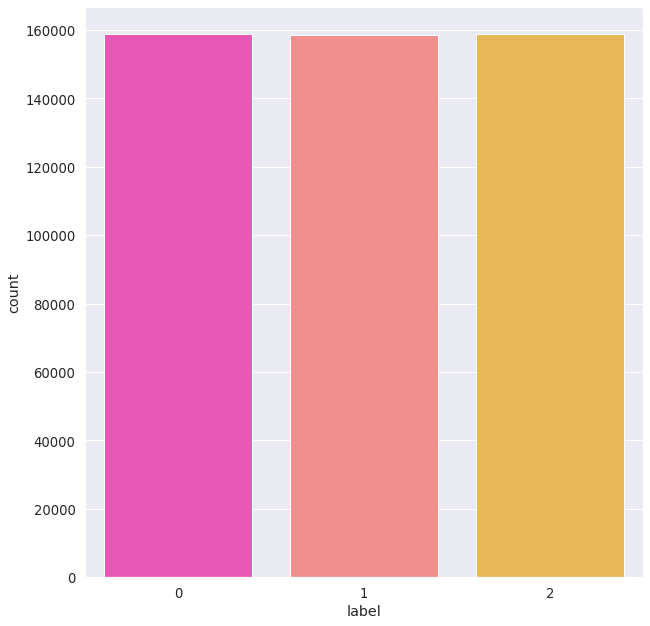

In [4]:
# Label Distribution in the dataset
plt.rcParams['figure.figsize'] = [10, 10.5]
sns.set(style = 'darkgrid', font_scale = 1.2)
label_sns = sns.countplot(df['label'], palette = 'spring')

### Language Distribution

Max :  404456
Min :  5111


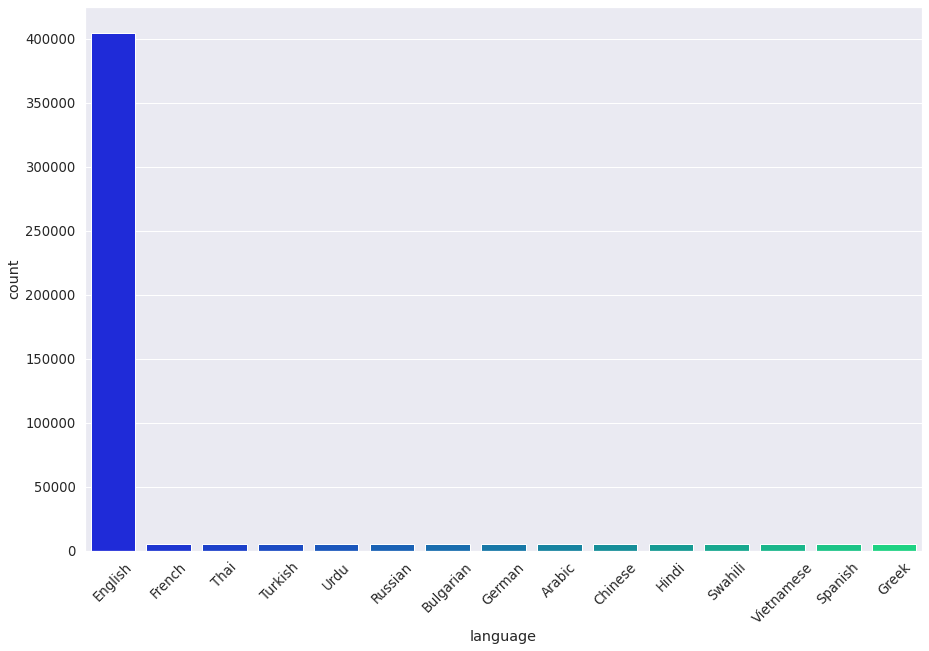

In [5]:
# Languages given in the dataset
plt.rcParams['figure.figsize'] = [15, 10]
sns.set(style = 'darkgrid', font_scale = 1.2)
lang_sns = sns.countplot(df['language'], palette = 'winter')
plt.setp(lang_sns.get_xticklabels(), rotation = 45);
print ("Max : ", df['lang_abv'].value_counts().max())
print ("Min : ", df['lang_abv'].value_counts().min())

### Part of Speech Tagging (English)

For Part of speech tagging of other languages, visit the documentation and download the model for the particular language and load as given in the next code cell  - https://spacy.io/usage/models

In [6]:
import spacy
sp = spacy.load('en_core_web_sm')

def POS_tag(sentence):
    sen = sp(sentence)
    print (sentence, "\n")
    for word in sen:
        print(f'{word.text:{12}} {word.pos_:{10}} {word.tag_:{8}} {spacy.explain(word.tag_)}')
    displacy.render(sen, style='dep', jupyter=True, options={'distance': 85})

In [7]:
examples = df.loc[df.lang_abv == 'en', 'premise']
examples = list(examples)
sen_1 = examples[0]
sen_2 = examples[1]
sen_3 = examples[2]

In [8]:
POS_tag(sen_1)

and these comments were considered in formulating the interim rules. 

and          CCONJ      CC       conjunction, coordinating
these        DET        DT       determiner
comments     NOUN       NNS      noun, plural
were         AUX        VBD      verb, past tense
considered   VERB       VBN      verb, past participle
in           ADP        IN       conjunction, subordinating or preposition
formulating  VERB       VBG      verb, gerund or present participle
the          DET        DT       determiner
interim      ADJ        JJ       adjective
rules        NOUN       NNS      noun, plural
.            PUNCT      .        punctuation mark, sentence closer


In [9]:
POS_tag(sen_2)

These are issues that we wrestle with in practice groups of law firms, she said.  

These        DET        DT       determiner
are          AUX        VBP      verb, non-3rd person singular present
issues       NOUN       NNS      noun, plural
that         DET        WDT      wh-determiner
we           PRON       PRP      pronoun, personal
wrestle      VERB       VBP      verb, non-3rd person singular present
with         ADP        IN       conjunction, subordinating or preposition
in           ADP        IN       conjunction, subordinating or preposition
practice     NOUN       NN       noun, singular or mass
groups       NOUN       NNS      noun, plural
of           ADP        IN       conjunction, subordinating or preposition
law          NOUN       NN       noun, singular or mass
firms        NOUN       NNS      noun, plural
,            PUNCT      ,        punctuation mark, comma
she          PRON       PRP      pronoun, personal
said         VERB       VBD      verb, past tense

In [10]:
POS_tag(sen_3)

you know they can't really defend themselves like somebody grown uh say my age you know yeah 

you          PRON       PRP      pronoun, personal
know         VERB       VBP      verb, non-3rd person singular present
they         PRON       PRP      pronoun, personal
ca           VERB       MD       verb, modal auxiliary
n't          PART       RB       adverb
really       ADV        RB       adverb
defend       VERB       VB       verb, base form
themselves   PRON       PRP      pronoun, personal
like         SCONJ      IN       conjunction, subordinating or preposition
somebody     PRON       NN       noun, singular or mass
grown        VERB       VBN      verb, past participle
uh           INTJ       UH       interjection
say          VERB       VBP      verb, non-3rd person singular present
my           DET        PRP$     pronoun, possessive
age          NOUN       NN       noun, singular or mass
you          PRON       PRP      pronoun, personal
know         VERB       VBP      v

### Sentiment (Polarity), Subjectivity and Objectivity of the Sentences

In [11]:
# Translating both Premise and Hypothesis in English for polarity and subjectivity (takes a long time to run)

# converted_premise = []
# converted_hypothesis = []
# for i in tqdm(range(len(df))):
#     if df['lang_abv'][i] != 'en':
#         converted_text_p = trans.translate(df['premise'][i]).text
#         converted_text_h = trans.translate(df['hypothesis'][i]).text
#         converted_premise.append(converted_text_p)
#         converted_hypothesis.append(converted_text_h)
#     else:
#         converted_premise.append(df['premise'][i])
#         converted_hypothesis.append(df['hypothesis'][i])
        

# df['premise_conv'] = converted_premise
# df['hypothesis_conv'] = converted_hypothesis

# df.head(10)

premise_eng = df.loc[df.lang_abv == 'en', 'premise'].values.tolist()
hypothesis_eng = df.loc[df.lang_abv == 'en', 'hypothesis'].values.tolist()

In [12]:
li_pol_p = []
li_sub_p = []
for i in tqdm(premise_eng):
    text = TextBlob(i)
    pol = text.sentiment.polarity
    sub = text.sentiment.subjectivity
    li_pol_p.append(pol)
    li_sub_p.append(sub)
    
li_pol_h = []
li_sub_h = []
for i in tqdm(hypothesis_eng):
    text = TextBlob(i)
    pol = text.sentiment.polarity
    sub = text.sentiment.subjectivity
    li_pol_h.append(pol)
    li_sub_h.append(sub)

100%|██████████| 404456/404456 [01:27<00:00, 4623.42it/s]


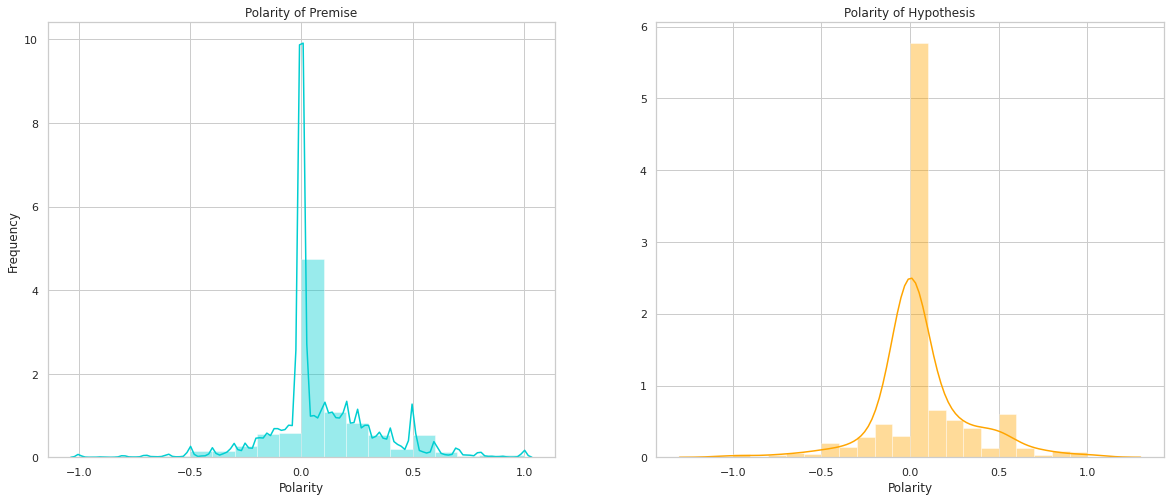

In [13]:
# Polarity Distribution of Premise and Hypothesis
plt.rcParams['figure.figsize'] = [20, 8]
sns.set(style = 'whitegrid')

plt.subplot(1, 2, 1)
sns.distplot(li_pol_p, bins = 20, color = 'darkturquoise')
plt.title('Polarity of Premise')
plt.xlabel('Polarity')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.distplot(li_pol_h, bins = 20, color = 'orange', kde_kws={'bw': 0.1})
plt.title('Polarity of Hypothesis')
plt.xlabel('Polarity');

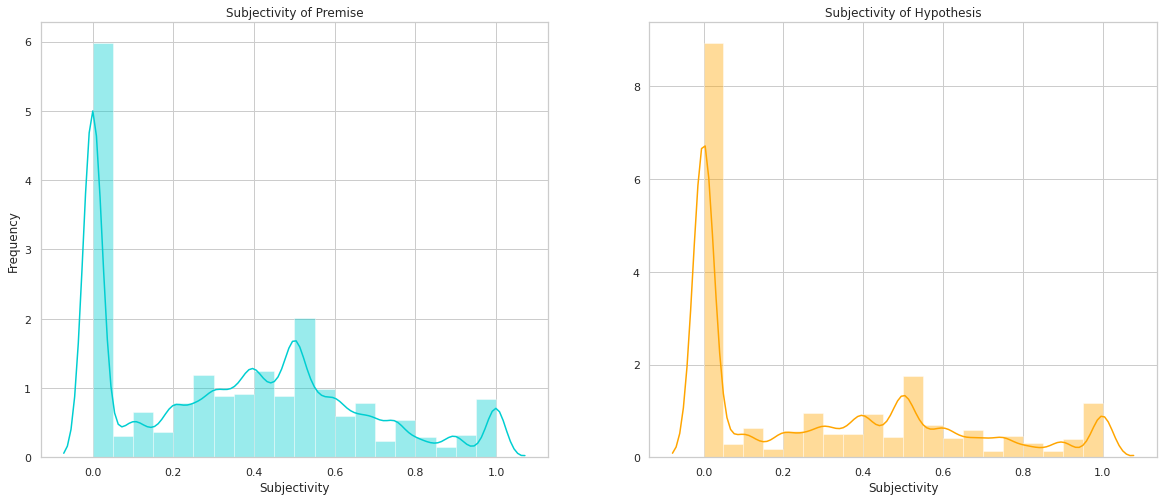

In [14]:
# Subjectivity Distribution of Premise and Hypothesis
plt.rcParams['figure.figsize'] = [20, 8]
sns.set(style = 'whitegrid')

plt.subplot(1, 2, 1)
sns.distplot(li_sub_p, bins = 20, color = 'darkturquoise')
plt.title('Subjectivity of Premise')
plt.xlabel('Subjectivity')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.distplot(li_sub_h, bins = 20, color = 'orange')
plt.title('Subjectivity of Hypothesis')
plt.xlabel('Subjectivity');

### Word Clouds

#### Word Cloud for English

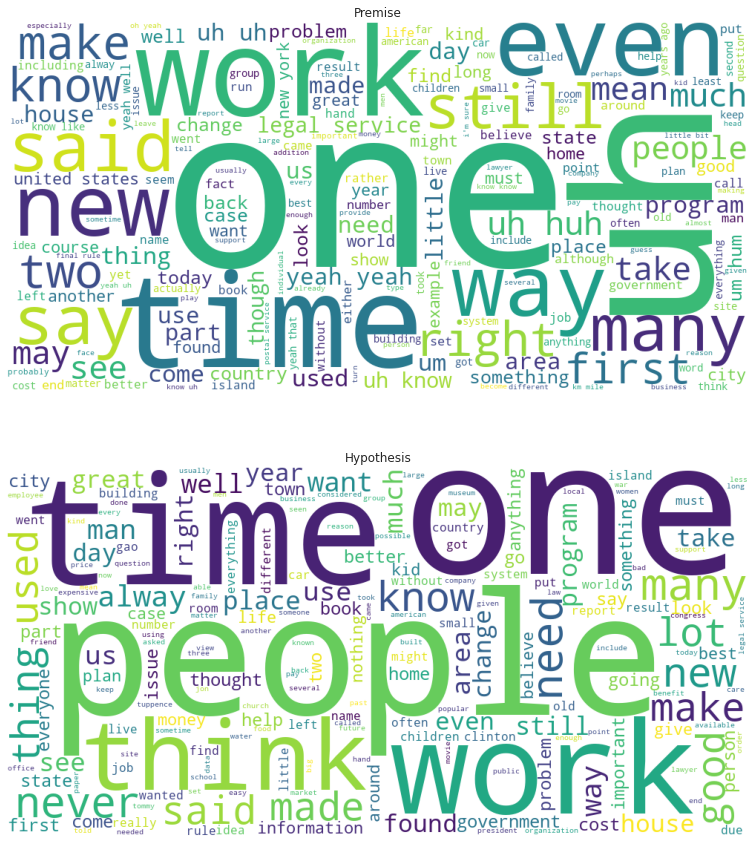

In [15]:
# Word Cloud Representation for the sentences in English
fig, ax = plt.subplots(2, 1, figsize=(30, 15))
stop_words_en = set(stopwords.words('english'))

english_sent = df.loc[df.lang_abv == 'en', ['premise', 'hypothesis']].copy()
english_sent['premise'] = english_sent['premise'].str.lower()
english_sent['hypothesis'] = english_sent['hypothesis'].str.lower()

# Removing the stopwords just for the visualization
english_sent['premise'] = english_sent['premise'].apply(lambda x: " ".join(word for word in x.split() if word not in stop_words_en))
english_sent['hypothesis'] = english_sent['hypothesis'].apply(lambda x: " ".join(word for word in x.split() if word not in stop_words_en))

text_hypo = (' '.join(english_sent['hypothesis']))
text = (' '.join(english_sent['premise']))

# WORDCLOUD
cloud = WordCloud(width = 1000, height = 500, background_color = 'white').generate(text)
ax[0].axis("off")
ax[0].title.set_text("Premise")
ax[0].imshow(cloud)
time.sleep(0.01)

cloud_1 = WordCloud(width = 1000, height = 500, background_color = 'white').generate(text_hypo)
ax[1].axis("off")
ax[1].title.set_text("Hypothesis")
ax[1].imshow(cloud_1);

#### Word Cloud for Spanish

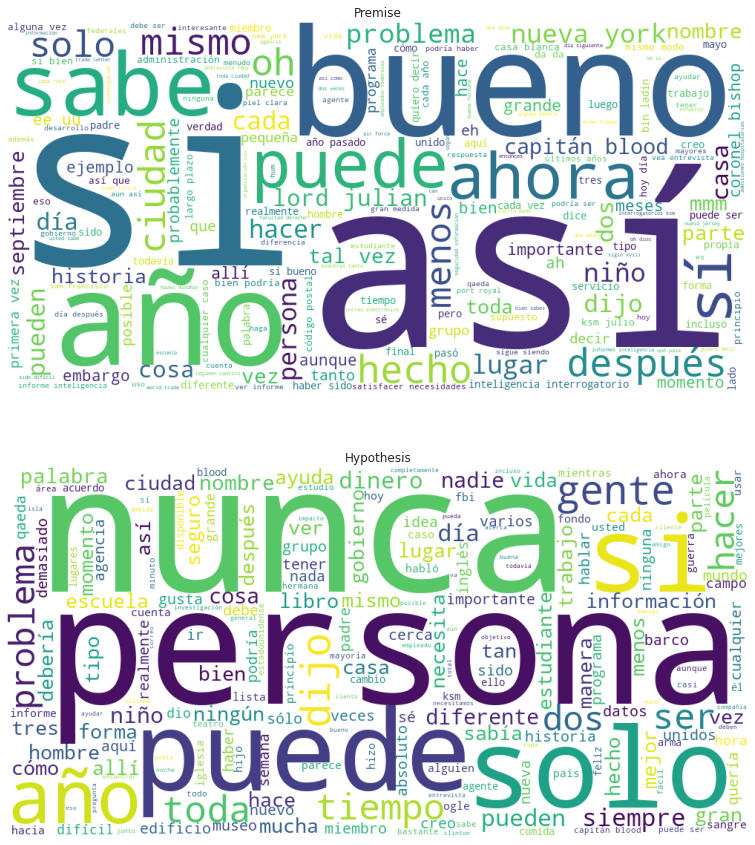

In [16]:
# Word Cloud Representation for the sentences in Spanish
fig, ax = plt.subplots(2, 1, figsize=(30, 15))
stop_words_es = set(stopwords.words('spanish'))

english_sent = df.loc[df.lang_abv == 'es', ['premise', 'hypothesis']].copy()
english_sent['premise'] = english_sent['premise'].str.lower()
english_sent['hypothesis'] = english_sent['hypothesis'].str.lower()

# Removing the stopwords just for the visualization
english_sent['premise'] = english_sent['premise'].apply(lambda x: " ".join(word for word in x.split() if word not in stop_words_es))
english_sent['hypothesis'] = english_sent['hypothesis'].apply(lambda x: " ".join(word for word in x.split() if word not in stop_words_es))

text_hypo = (' '.join(english_sent['hypothesis']))
text = (' '.join(english_sent['premise']))

# WORDCLOUD
cloud = WordCloud(width = 1000, height = 500, background_color = 'white').generate(text)
ax[0].axis("off")
ax[0].title.set_text("Premise")
ax[0].imshow(cloud)
time.sleep(0.01)

cloud_1 = WordCloud(width = 1000, height = 500, background_color = 'white').generate(text_hypo)
ax[1].axis("off")
ax[1].title.set_text("Hypothesis")
ax[1].imshow(cloud_1);

#### Word Cloud for French

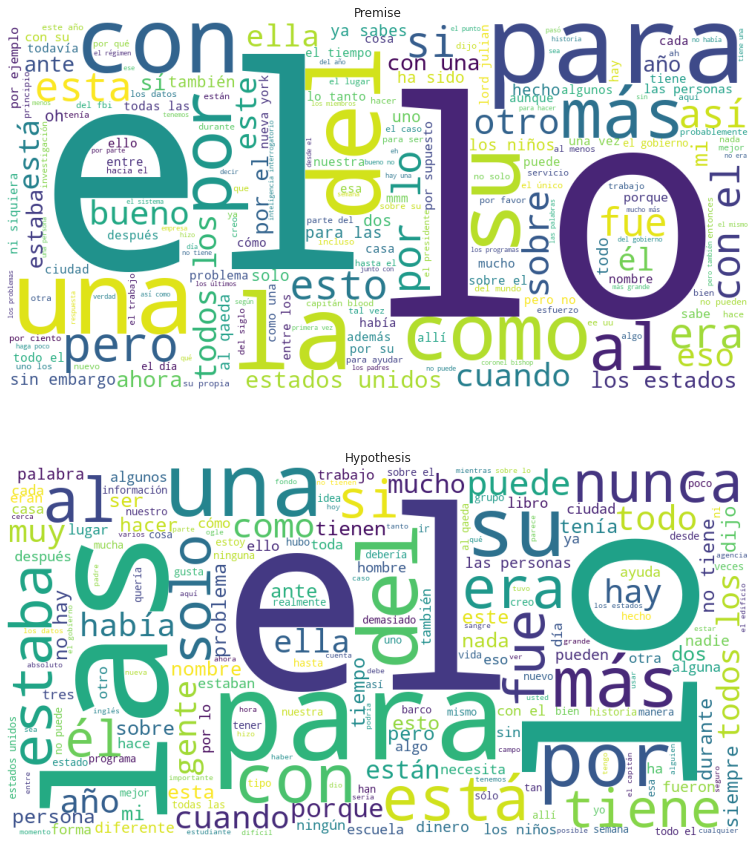

In [17]:
# Word Cloud Representation for the sentences in French
fig, ax = plt.subplots(2, 1, figsize=(30, 15))
stop_words_fr = set(stopwords.words('french'))

english_sent = df.loc[df.lang_abv == 'es', ['premise', 'hypothesis']].copy()
english_sent['premise'] = english_sent['premise'].str.lower()
english_sent['hypothesis'] = english_sent['hypothesis'].str.lower()

# Removing the stopwords just for the visualization
english_sent['premise'] = english_sent['premise'].apply(lambda x: " ".join(word for word in x.split() if word not in stop_words_fr))
english_sent['hypothesis'] = english_sent['hypothesis'].apply(lambda x: " ".join(word for word in x.split() if word not in stop_words_fr))

text_hypo = (' '.join(english_sent['hypothesis']))
text = (' '.join(english_sent['premise']))

# WORDCLOUD
cloud = WordCloud(width = 1000, height = 500, background_color = 'white').generate(text)
ax[0].axis("off")
ax[0].title.set_text("Premise")
ax[0].imshow(cloud)
time.sleep(0.01)

cloud_1 = WordCloud(width = 1000, height = 500, background_color = 'white').generate(text_hypo)
ax[1].axis("off")
ax[1].title.set_text("Hypothesis")
ax[1].imshow(cloud_1);

### Ngrams

#### Unigrams

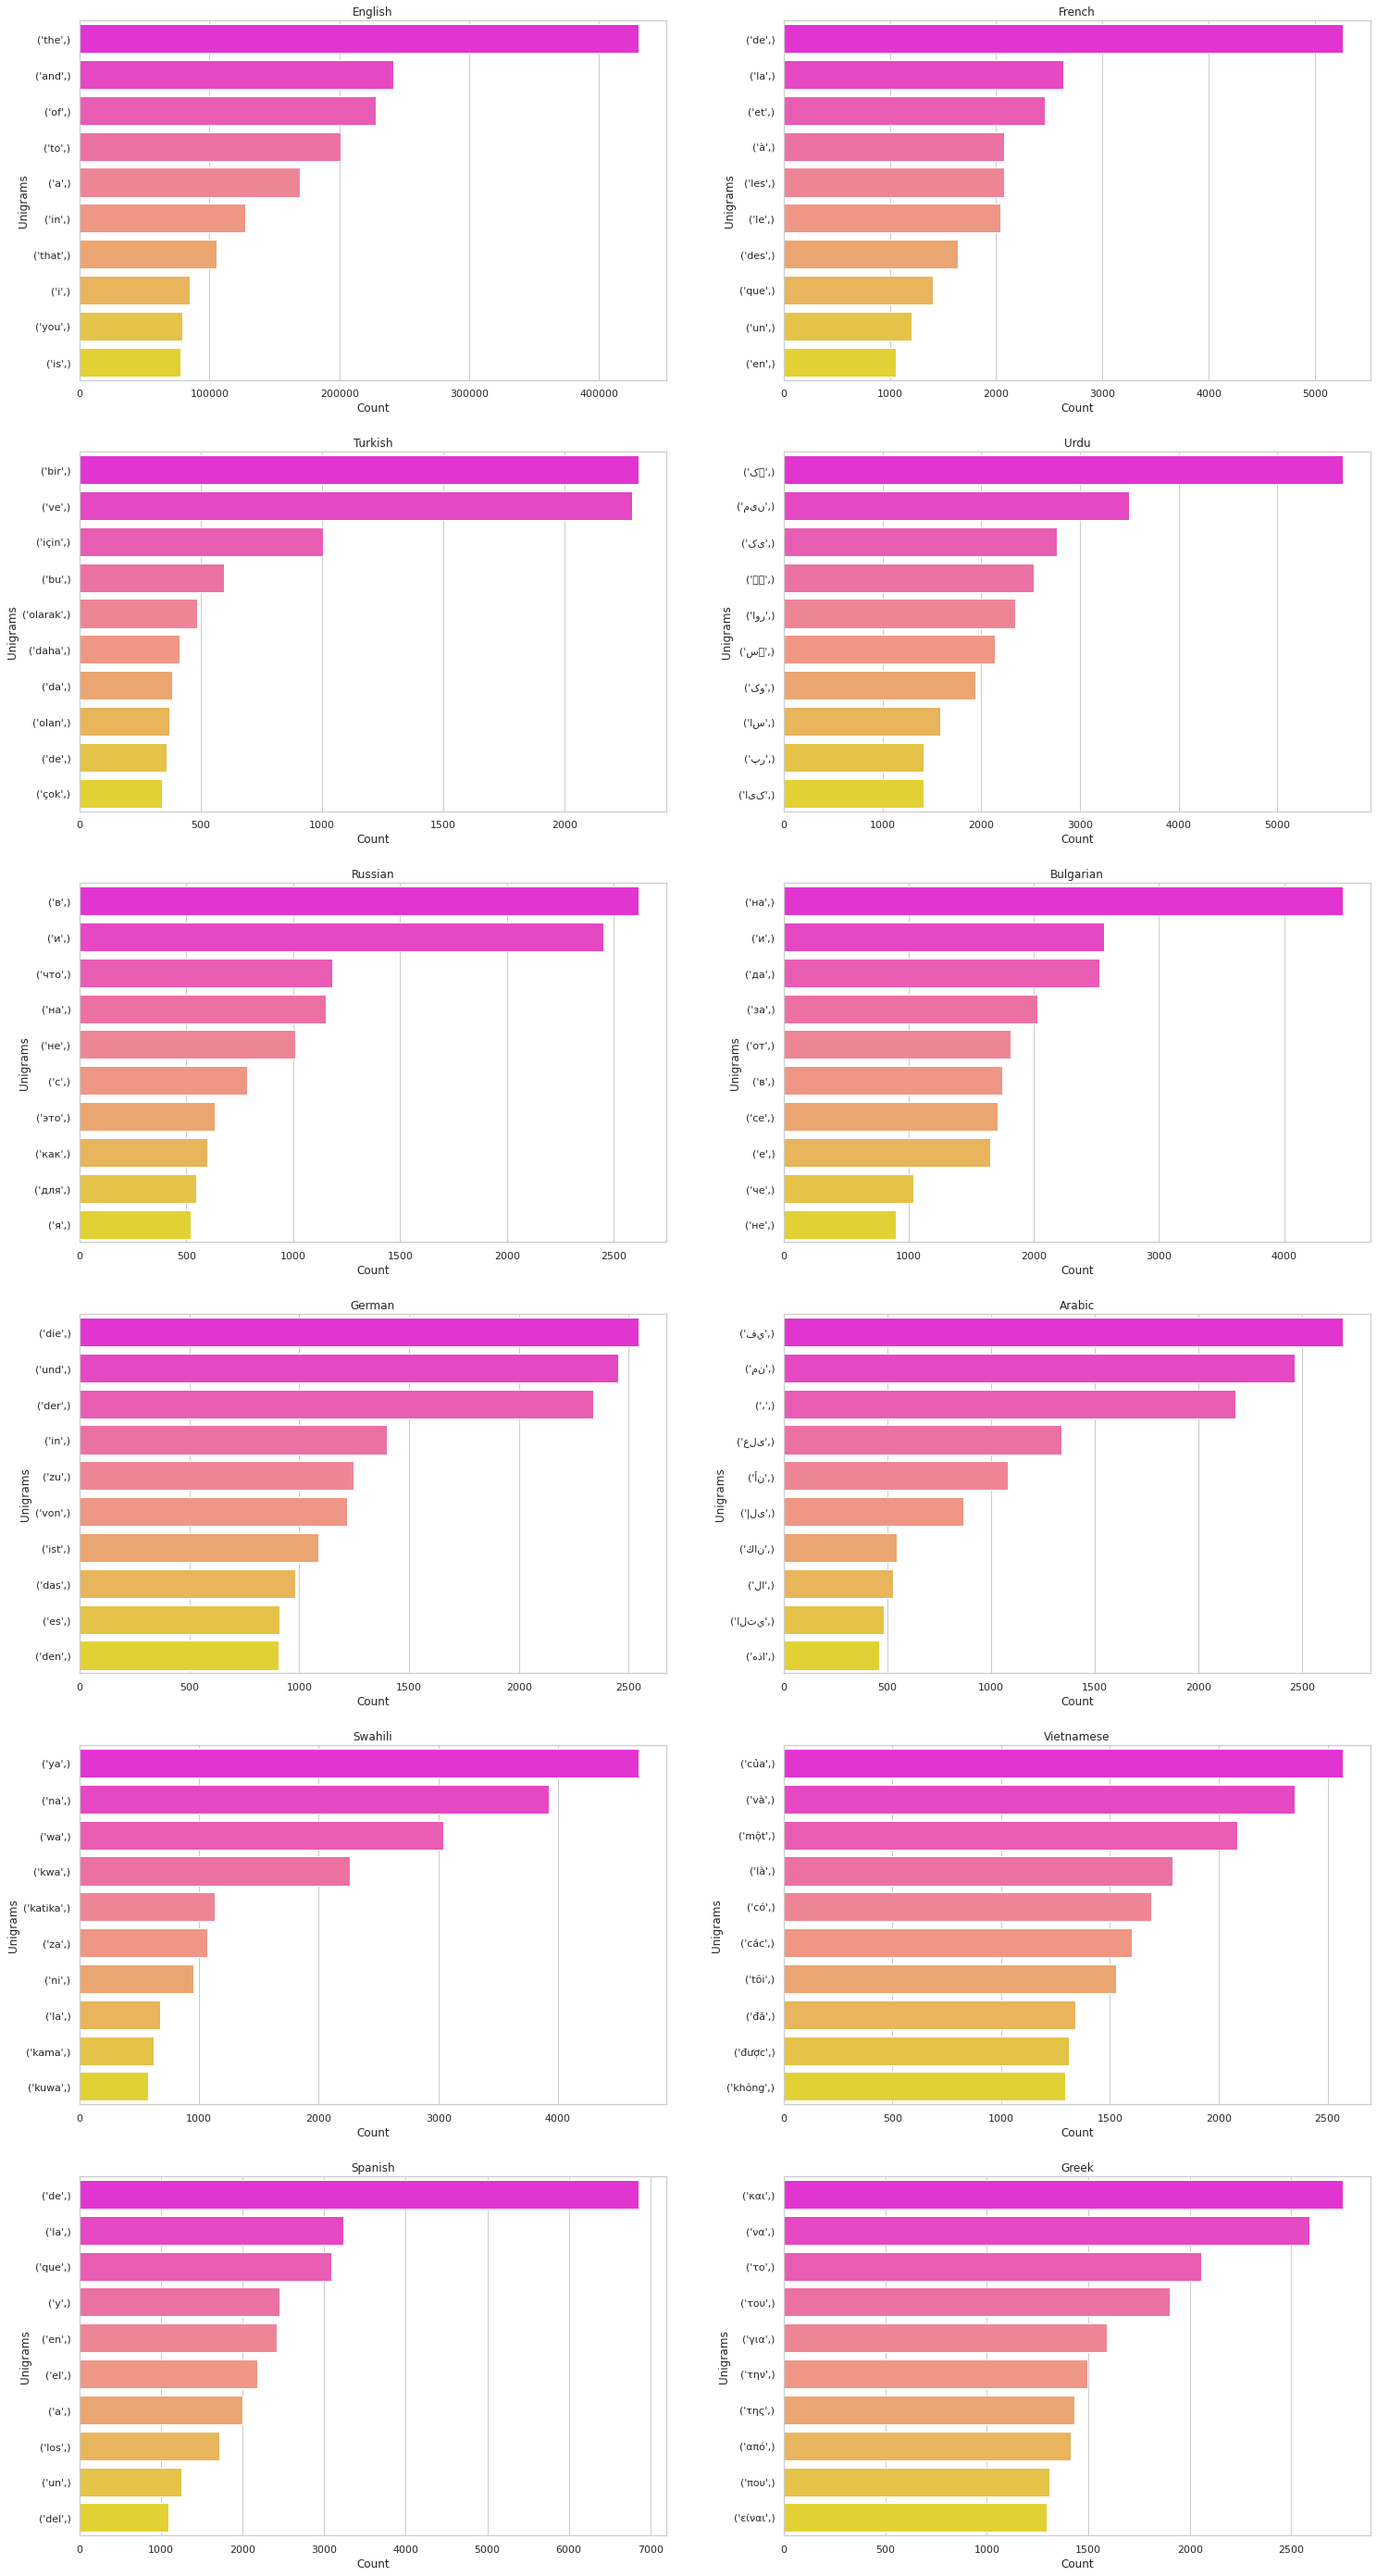

In [18]:
# Premise Unigrams
fig, ax = plt.subplots(6, 2, figsize=(25, 50))
sns.set(style = 'whitegrid')
plt.rcParams['font.sans-serif'] = ['Source Han Sans TW', 'sans-serif']
languages = list(df.language.unique())
languages = [l for l in languages if l not in ('Thai', 'Chinese', 'Hindi')]

for i, lang in enumerate(languages):
    lang_premise = df.loc[df.language == lang, 'premise']
    text_ = ' '.join(lang_premise)
    # Removing the punctuations
    text = ''.join(word for word in text_ if word not in punctuation)
    # Unigrams
    unigram = ngrams(word_tokenize(text), 1)
    count = Counter(unigram)
    temp_df = pd.DataFrame(count.most_common(10))
    # Plot
    lng_plot = sns.barplot(x = temp_df[1], y = temp_df[0], ax = ax.flatten()[i], palette = 'spring')
    ax.flatten()[i].set(xlabel='Count', ylabel='Unigrams', title = lang)

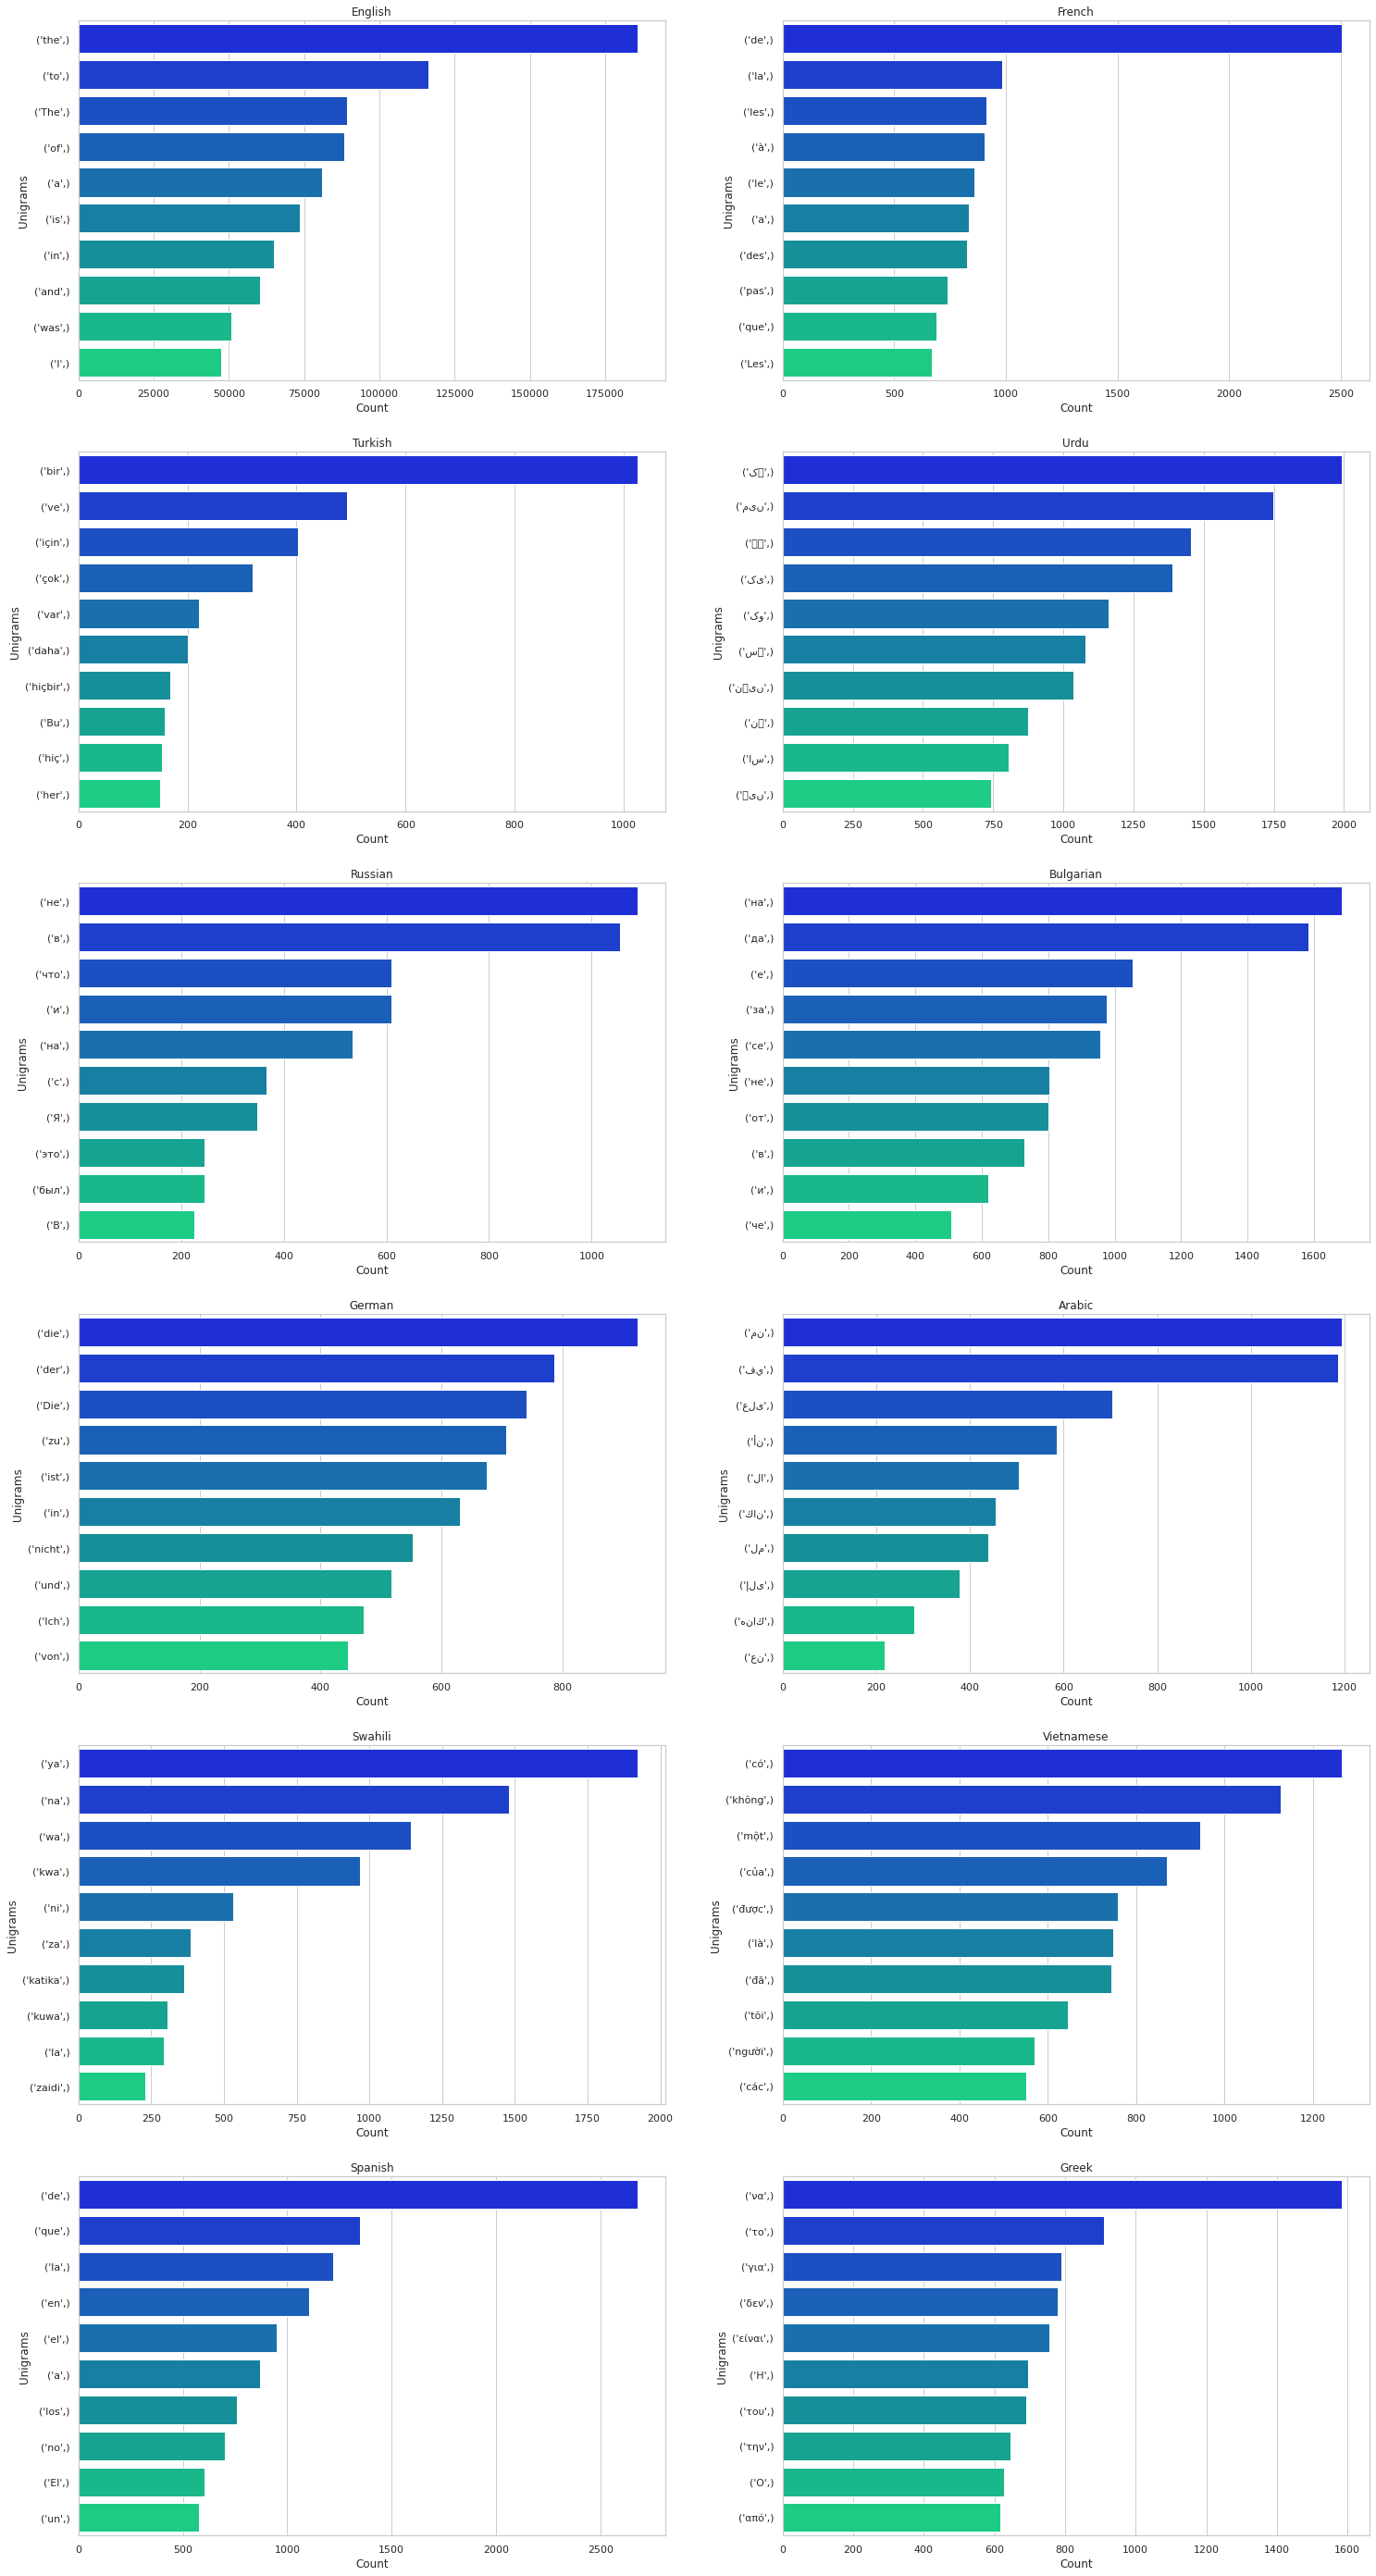

In [19]:
# Hypothesis Unigrams
fig, ax = plt.subplots(6, 2, figsize=(25, 50))
sns.set(style = 'whitegrid')
plt.rcParams['font.sans-serif'] = ['Source Han Sans TW', 'sans-serif']

for i, lang in enumerate(languages):
    lang_premise = df.loc[df.language == lang, 'hypothesis']
    text_ = ' '.join(lang_premise)
    # Removing the punctuations
    text = ''.join(word for word in text_ if word not in punctuation)
    # Unigrams
    unigram = ngrams(word_tokenize(text), 1)
    count = Counter(unigram)
    temp_df = pd.DataFrame(count.most_common(10))
    # Plot
    lng_plot = sns.barplot(x = temp_df[1], y = temp_df[0], ax = ax.flatten()[i], palette = 'winter')
    ax.flatten()[i].set(xlabel='Count', ylabel='Unigrams', title = lang)

#### Bigrams

In [20]:
# # Premise Bigrams
# fig, ax = plt.subplots(6, 2, figsize=(25, 50))
# sns.set(style = 'whitegrid')
# plt.rcParams['font.sans-serif'] = ['Source Han Sans TW', 'sans-serif']

# for i, lang in enumerate(languages):
#     lang_premise = df.loc[df.language == lang, 'premise']
#     text_ = ' '.join(lang_premise)
#     # Removing the punctuations
#     text = ''.join(word for word in text_ if word not in punctuation)
#     # Bigrams
#     bigram = ngrams(word_tokenize(text), 2)
#     count = Counter(bigram)
#     temp_df = pd.DataFrame(count.most_common(10))
#     # Plot
#     lng_plot = sns.barplot(x = temp_df[1], y = temp_df[0], ax = ax.flatten()[i])
#     ax.flatten()[i].set(xlabel='Count', ylabel='Bigrams', title = lang)

In [21]:
# # Hypothesis Bigrams
# fig, ax = plt.subplots(6, 2, figsize=(25, 50))
# sns.set(style = 'whitegrid')
# plt.rcParams['font.sans-serif'] = ['Source Han Sans TW', 'sans-serif']

# for i, lang in enumerate(languages):
#     lang_premise = df.loc[df.language == lang, 'hypothesis']
#     text_ = ' '.join(lang_premise)
#     # Removing the punctuations
#     text = ''.join(word for word in text_ if word not in punctuation)
#     # Bigrams
#     bigram = ngrams(word_tokenize(text), 2)
#     count = Counter(bigram)
#     temp_df = pd.DataFrame(count.most_common(10))
#     # Plot
#     lng_plot = sns.barplot(x = temp_df[1], y = temp_df[0], ax = ax.flatten()[i])
#     ax.flatten()[i].set(xlabel='Count', ylabel='Bigrams', title = lang)

#### Trigrams

In [22]:
# # Premise Trigrams
# fig, ax = plt.subplots(6, 2, figsize=(25, 50))
# sns.set(style = 'whitegrid')
# plt.rcParams['font.sans-serif'] = ['Source Han Sans TW', 'sans-serif']

# for i, lang in enumerate(languages):
#     lang_premise = df.loc[df.language == lang, 'premise']
#     text_ = ' '.join(lang_premise)
#     # Removing the punctuations
#     text = ''.join(word for word in text_ if word not in punctuation)
#     # Trigrams
#     trigram = ngrams(word_tokenize(text), 3)
#     count = Counter(trigram)
#     temp_df = pd.DataFrame(count.most_common(10))
#     # Plot
#     lng_plot = sns.barplot(x = temp_df[1], y = temp_df[0], ax = ax.flatten()[i])
#     ax.flatten()[i].set(xlabel='Count', ylabel='Trigrams', title = lang)

In [23]:
# # Hypothesis Trigrams
# fig, ax = plt.subplots(6, 2, figsize=(25, 50))
# sns.set(style = 'whitegrid')
# plt.rcParams['font.sans-serif'] = ['Source Han Sans TW', 'sans-serif']

# for i, lang in enumerate(languages):
#     lang_premise = df.loc[df.language == lang, 'hypothesis']
#     text_ = ' '.join(lang_premise)
#     # Removing the punctuations
#     text = ''.join(word for word in text_ if word not in punctuation)
#     # Trigrams
#     trigram = ngrams(word_tokenize(text), 3)
#     count = Counter(trigram)
#     temp_df = pd.DataFrame(count.most_common(10))
#     # Plot
#     lng_plot = sns.barplot(x = temp_df[1], y = temp_df[0], ax = ax.flatten()[i])
#     ax.flatten()[i].set(xlabel='Count', ylabel='Trigrams', title = lang)

### Word Frequency Plot (English)

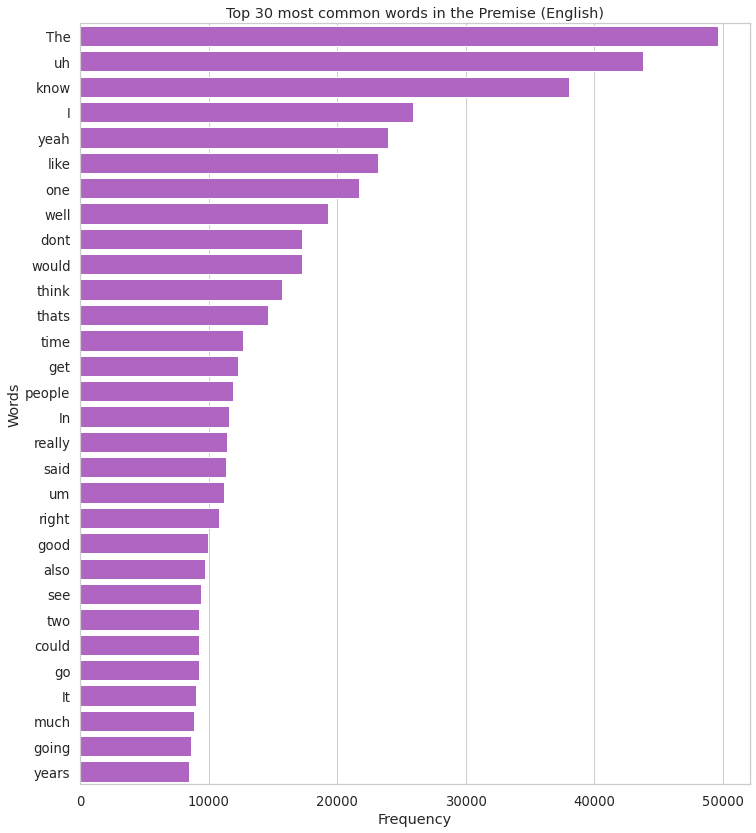

In [24]:
# Word Frequecy plot after removing stopwords in Premise

text_premise = " ".join(df.loc[df.lang_abv == 'en', 'premise'])
text = ''.join(word for word in text_premise if word not in punctuation)
t = " ".join(word for word in text.split() if word not in stop_words_en)
tokenized_premise = word_tokenize(t)
frequency_premise = Counter(tokenized_premise)
df_2 = pd.DataFrame(frequency_premise.most_common(30))

sns.set(font_scale = 1.2, style = 'whitegrid')
plt.rcParams['figure.figsize'] = [12, 14]

word_count_2 = sns.barplot(x = df_2[1], y = df_2[0], color = 'mediumorchid')
word_count_2.set(title = 'Top 30 most common words in the Premise (English)', xlabel = 'Frequency',
                ylabel = 'Words');

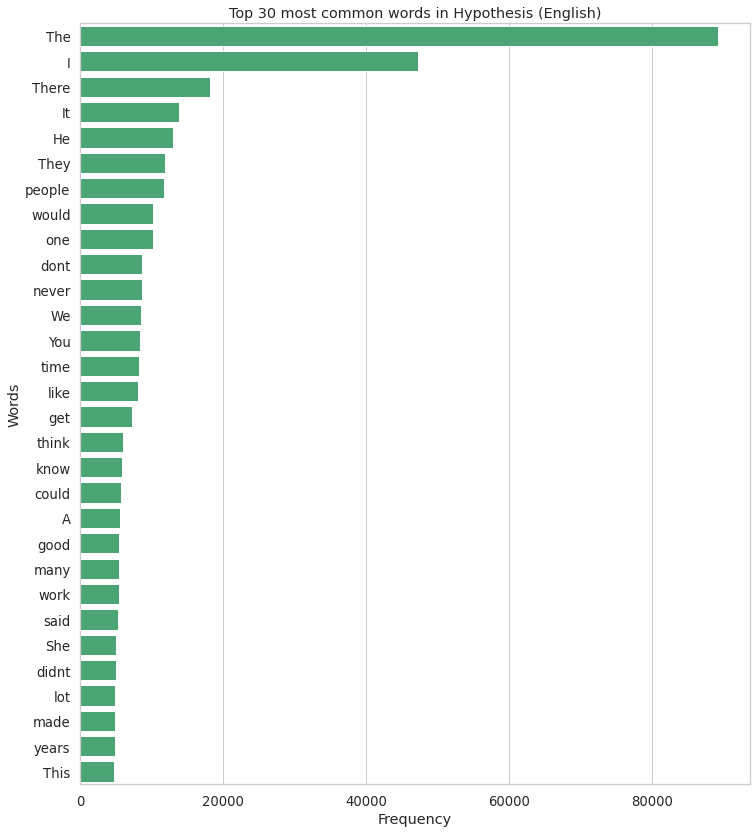

In [25]:
# Word Frequecy plot after removing stopwords in Hypothesis

text_hypothesis = " ".join(df.loc[df.lang_abv == 'en', 'hypothesis'])
text_h = ''.join(word for word in text_hypothesis if word not in punctuation)
t_h = " ".join(word for word in text_h.split() if word not in stop_words_en)
tokenized_hypothesis = word_tokenize(t_h)
frequency_hypothesis = Counter(tokenized_hypothesis)
df_2 = pd.DataFrame(frequency_hypothesis.most_common(30))

sns.set(font_scale = 1.2, style = 'whitegrid')
plt.rcParams['figure.figsize'] = [12, 14]

word_count_2 = sns.barplot(x = df_2[1], y = df_2[0], color = 'mediumseagreen')
word_count_2.set(title = 'Top 30 most common words in Hypothesis (English)', xlabel = 'Frequency',
                ylabel = 'Words');